# Known Plumes 

From https://landweb.modaps.eosdis.nasa.gov/displayissue?id=339

Q's: 

- How does SNPP detect hotspots within the data?
- VNP14 user guide: https://viirsland.gsfc.nasa.gov/PDF/VIIRS_activefire_User_Guide.pdf
- User guide also references this guide which contains the science behind how VIIRS is detecting fires: https://viirsland.gsfc.nasa.gov/PDF/VIIRS_activefire_750m_ATBD.pdf


Things learned: 
- Sentinel 2 is much higher resolution than VIIRS
- VIIRS is at 500m or 1km and Sentinel is at ~ 10 m depending on what you download

In [1]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from cartopy import crs as ccrs
from geodatasets import get_path
import rioxarray as rxr 
import matplotlib.patches as mpatches
import time
import seaborn as sns

from glob import glob
import earthpy as et 
import earthpy.spatial as es
import earthpy.plot as ep 

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show 
from rasterio.plot import reshape_as_raster, reshape_as_image

import os 

from matplotlib.colors import ListedColormap

import plotly.graph_objects as go
from rasterio.plot import show 

from PIL import Image
import numpy as np

from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

ee.Authenticate()
ee.Initialize(project='karlzam')

## Carr: Whiskeytown Lake, California, July 26, 2018
Lat, Long: 40.658, -122.543 

In [6]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

path = get_path("naturalearth.land")
#world = gpd.read_file(path) #This doesn't work anymore...  "Invalid projection: EPSG:4326: (Internal Proj Error: proj_create: no database context specified)"
print(path)

# VIIRS_S-NPP
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-123,39,-121,41/1/2018-07-26'
df_SNPP = pd.read_csv(area_url_SNPP)
print(df_SNPP)

df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

#gdf_SNPP = gpd.GeoDataFrame(
#    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude))
#gdf_SNPP.head(3)\

#gdf_SNPP['confidence'].unique()
#gdf_SNPP['confidence'].hist()
# - L: low confidence (pixel class 7): daytime pixels are typically associated with areas of sunglint or water pixels, and lower relative temp anomaly (<15K) 
# - N: nominal confidence (pixel class 8): free from sunglint and marked by strong temp anomaly in either day or nighttime data (>15K)
# - H: high confidence (pixel class 9): day or nighttime pixels, including nominal saturation and digital number folding

transaction_limit             5000
current_transactions             0
transaction_interval    10 minutes
dtype: object

C:\Users\kzammit\AppData\Local\geodatasets\geodatasets\Cache\ne_110m_land.zip
     latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0    40.59661 -122.53164      303.52  0.43   0.46  2018-07-26       936   
1    40.59975 -122.51968      304.61  0.43   0.46  2018-07-26       936   
2    40.60027 -122.52510      305.88  0.43   0.46  2018-07-26       936   
3    40.60081 -122.53089      306.37  0.43   0.46  2018-07-26       936   
4    40.60356 -122.51467      307.55  0.42   0.46  2018-07-26       936   
..        ...        ...         ...   ...    ...         ...       ...   
652  40.70834 -122.59699      356.48  0.40   0.37  2018-07-26      2059   
653  40.71008 -122.60735      353.57  0.40   0.37  2018-07-26      2059   
654  40.71039 -122.54347      367.00  0.39   0.37  2018-07-26      2059   
655  40.71638 -122.56988      367.00  0.40   0.37  2018-07-26      2059   
656  40.71968 -122.57090      367.00  0.40   0.37  2018-07-26      2059   

    satellite instrum

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry
0,40.59661,-122.53164,303.52,0.43,0.46,2018-07-26,936,N,VIIRS,n,2,290.48,1.08,N,0,POINT (-122.53164 40.59661)
1,40.59975,-122.51968,304.61,0.43,0.46,2018-07-26,936,N,VIIRS,n,2,290.48,2.71,N,0,POINT (-122.51968 40.59975)
2,40.60027,-122.52510,305.88,0.43,0.46,2018-07-26,936,N,VIIRS,n,2,290.27,1.08,N,0,POINT (-122.5251 40.60027)


### Sentinel (from Sentinel Hub)

In [7]:
# Satellite data obtained from July 24-29 2018, Sentinel2-L2A
# The below are from July 27th 2018

bands_s = glob(r"C:\Users\kzammit\Documents\example-plumes\Sentinel\wt\*.tiff")
bands_s

['C:\\Users\\kzammit\\Documents\\example-plumes\\Sentinel\\wt\\2018-07-27-00_00_2018-07-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 'C:\\Users\\kzammit\\Documents\\example-plumes\\Sentinel\\wt\\2018-07-27-00_00_2018-07-27-23_59_Sentinel-2_L2A_B12_(Raw).tiff',
 'C:\\Users\\kzammit\\Documents\\example-plumes\\Sentinel\\wt\\2018-07-27-00_00_2018-07-27-23_59_Sentinel-2_L2A_False_color.tiff',
 'C:\\Users\\kzammit\\Documents\\example-plumes\\Sentinel\\wt\\2018-07-27-00_00_2018-07-27-23_59_Sentinel-2_L2A_True_color.tiff']

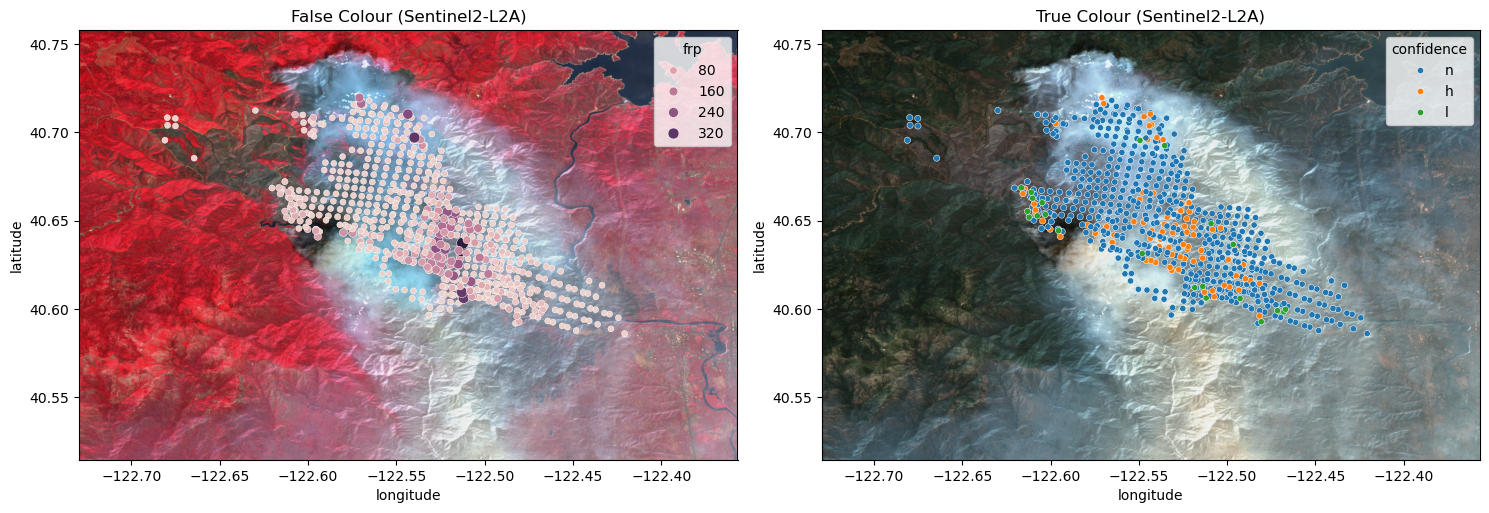

In [8]:
fc = rio.open(bands_s[2])
tc = rio.open(bands_s[3])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

# plot DEM
minx = min(gdf_SNPP.bounds['minx'])
miny = min(gdf_SNPP.bounds['miny'])
maxx = max(gdf_SNPP.bounds['maxx'])
maxy = max(gdf_SNPP.bounds['maxy'])

show(fc, ax=ax1)
#gdf_SNPP.plot(ax=ax1, color='orange', markersize=5, label='SNPP')
#sns.scatterplot(x="longitude", y="latitude", data=gdf_SNPP, hue="confidence", ax=ax1, s=20)
sns.scatterplot(x="longitude", y="latitude", data=gdf_SNPP, hue="frp", ax=ax1, size='frp')
ax1.title.set_text('False Colour (Sentinel2-L2A)')

show(tc, ax=ax2)
sns.scatterplot(x="longitude", y="latitude", data=gdf_SNPP, hue="confidence", ax=ax2, s=20)
ax2.title.set_text('True Colour (Sentinel2-L2A)')

handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

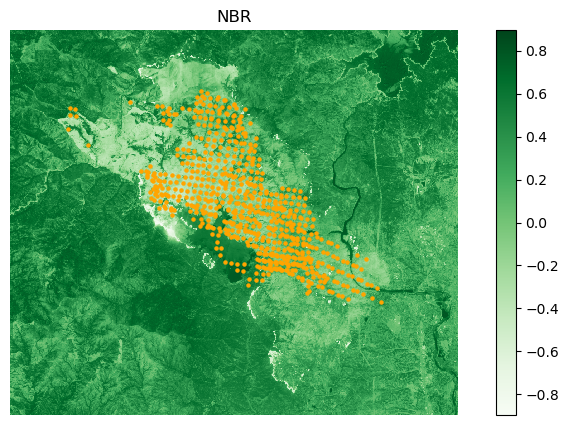

In [9]:
# Internet said for Sentinel 2, NBR is (B8-B12)/(B8+B12)

B8 = rxr.open_rasterio(bands_s[0], masked=True).squeeze()
B12 = rxr.open_rasterio(bands_s[1], masked=True).squeeze()

NBR = (B8-B12)/(B8+B12)

f, ax = plt.subplots(figsize=(10, 5))
NBR.plot(cmap="Greens")
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
ax.set(title="NBR")
ax.set_axis_off()
plt.show()

In [10]:
# Other method: worked but no coords

# Open both images and make into Numpy arrays of signed 32-bit integers
#B08 = np.array(Image.open(bands[0])).astype('int16')
#B12 = np.array(Image.open(bands[1])).astype('int16')

# Calculate difference with saturation
#NBR = np.clip(B08-B12/(B08+B12), 0, B12.max())

# Revert to PIL Image and save
#Image.fromarray(NBR.astype(np.uint16)).save(r'C:\Users\kzammit\Documents\example-plumes\NBR.tif')
#NBR_tiff = rio.open(r'C:\Users\kzammit\Documents\example-plumes\NBR.tif')
#show(NBR_tiff)

### VIIRS

Ok current problems: 
- reso is really low
- clouds in imagery
- sooo many viirs products i'm not sure which one to use
- how to export using gee to an image
- how to look at what's in an image collection: I think I need to take this off of jupyter lab

In [11]:
Map = geemap.Map()

start_date = '2018-07-25'
end_date = '2018-07-27'

# -123,39,-121,41
roi = ee.Geometry.Rectangle([-123.0, 39.0, -121.0, 41.0]) 

# Get VIIRS data 
# VNP09GA: Surface reflectance daily
viirs_collection = ee.ImageCollection("NASA/VIIRS/002/VNP09GA") \
    .filterDate(start_date, end_date) \
    .filterBounds(roi)

# .first() can give first image

rgb = viirs_collection.select(['M5', 'M4', 'M3'])

# Define VIIRS bands we'll be using 
rgbVis = {'bands': ['M5', 'M4', 'M3'], 'min':0, 'max':0.3}

# Create clipped sat data from the image collection
image = rgb.median()
# median can get rid of extremes 
# sort by cloud cover after collection, take the clearest image (for this application it might not be the way to go) 
# print viirs collection and look at metadata, call that specific image instead of the collection 
# pull that image for the time 
clipped = image.clip(roi)
# Add layer to the map
Map.addLayer(clipped, rgbVis, 'Clipped')

# This converts the hotspots into a geo interface so I can plot overtop of the map
geojson = gdf_SNPP.__geo_interface__

Map.add_geojson(geojson, layer_name='GeoDataFrame', style={'color': 'blue', 'weight': 2})
Map.addLayer(rgb, rgbVis, 'RGB', 'shown'==0)
Map.centerObject(roi, 9)

Map

Map(center=[39.99941297150512, -122.0000000000002], controls=(WidgetControl(options=['position', 'transparent_…

In [12]:
# https://courses.spatialthoughts.com/end-to-end-gee.html#exporting-data

rgb_2 = viirs_collection.select(['I1', 'I2', 'I3'])

# Define VIIRS bands we'll be using 
rgbVis_2 = {'bands': ['I1', 'I2', 'I3'], 'min':0, 'max':0.5}

# Create clipped sat data from the image collection
image_2 = rgb_2.median()
clipped_2 = image_2.clip(roi)
# Add layer to the map
Map.addLayer(clipped_2, rgbVis_2, 'Clipped_2')

In [13]:
# This selects all bands that start with an "M" like in the example (but they had B)
exportImage = clipped.select('M.*')

# Define the export parameters
export_task = ee.batch.Export.image.toDrive(
    image=exportImage,
    description='VIIRS_RGB_Export',
    folder='GEE_Exports',  # Change this to your preferred folder in Google Drive
    fileNamePrefix='viirs_rgb_raw',
    region=roi,  # Define the region to export
    scale=500,  # Scale in meters
    crs='EPSG:4326',  # Coordinate reference system
    maxPixels=1e13  # Maximum number of pixels to export
)

# Start the export task
export_task.start()

while export_task.active():
    print('Polling for task (id: {}).'.format(export_task.id))
    time.sleep(10)

print('Task completed with status: ', export_task.status())

Polling for task (id: 6CKOZ3JJXNW5WWZI5CP4NR4N).
Polling for task (id: 6CKOZ3JJXNW5WWZI5CP4NR4N).
Task completed with status:  {'state': 'COMPLETED', 'description': 'VIIRS_RGB_Export', 'priority': 100, 'creation_timestamp_ms': 1728499280731, 'update_timestamp_ms': 1728499294538, 'start_timestamp_ms': 1728499284788, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1zw0Ee4ORaVtq15mcbSIIZqexq45rHhFe'], 'attempt': 1, 'batch_eecu_usage_seconds': 1.984521508216858, 'id': '6CKOZ3JJXNW5WWZI5CP4NR4N', 'name': 'projects/karlzam/operations/6CKOZ3JJXNW5WWZI5CP4NR4N'}


In [14]:
# This selects all bands that start with an "M" like in the example (but they had B)
exportImage_2 = clipped_2.select('I.*')

# Define the export parameters
export_task = ee.batch.Export.image.toDrive(
    image=exportImage_2,
    description='VIIRS_RGB_Export',
    folder='GEE_Exports',  # Change this to your preferred folder in Google Drive
    fileNamePrefix='viirs_rgb_raw_imagery',
    region=roi,  # Define the region to export
    scale=500,  # Scale in meters
    crs='EPSG:4326',  # Coordinate reference system
    maxPixels=1e13  # Maximum number of pixels to export
)

# Start the export task
export_task.start()

while export_task.active():
    print('Polling for task (id: {}).'.format(export_task.id))
    time.sleep(10)

print('Task completed with status: ', export_task.status())

Polling for task (id: SOYILVT7ZNDEPN3SGOMNBXHU).
Polling for task (id: SOYILVT7ZNDEPN3SGOMNBXHU).
Task completed with status:  {'state': 'COMPLETED', 'description': 'VIIRS_RGB_Export', 'priority': 100, 'creation_timestamp_ms': 1728499301931, 'update_timestamp_ms': 1728499317798, 'start_timestamp_ms': 1728499305829, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1zw0Ee4ORaVtq15mcbSIIZqexq45rHhFe'], 'attempt': 1, 'batch_eecu_usage_seconds': 1.386997103691101, 'id': 'SOYILVT7ZNDEPN3SGOMNBXHU', 'name': 'projects/karlzam/operations/SOYILVT7ZNDEPN3SGOMNBXHU'}


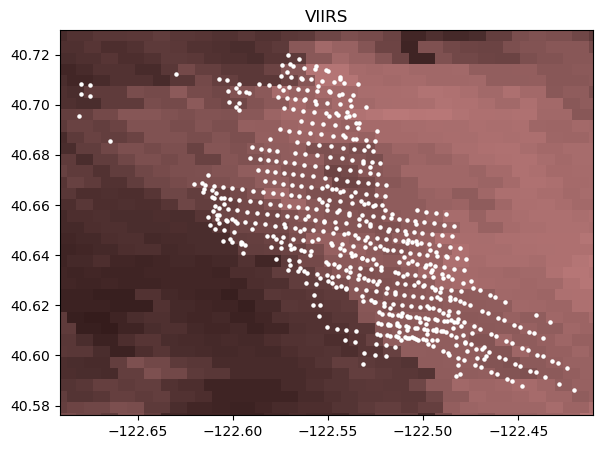

In [15]:
import rasterio
from rasterio.plot import show
fp = r'C:\Users\kzammit\Documents\VIIRS-data-GEE\viirs_rgb_raw.tif'
img = rasterio.open(fp)

f, ax = plt.subplots(figsize=(10, 5))
#show(img.read(), ax=ax, transform=img.transform)
show(img, ax=ax, cmap='pink')
gdf_SNPP.plot(ax=ax, color='white', markersize=5, label='SNPP')
ax.set(title="VIIRS")

buffer = 0.01
plt.xlim(minx-buffer, maxx+buffer)
plt.ylim(miny-buffer, maxy+buffer)
plt.show()

### Landsat

In [22]:
Map = geemap.Map()

start_date = '2018-07-25'
end_date = '2018-07-27'

# -123,39,-121,41
roi = ee.Geometry.Rectangle([-123.0, 39.0, -121.0, 41.0]) 

# Get VIIRS data 
landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterDate(start_date, end_date) \
    .filterBounds(roi)

true_color_432 = landsat_collection.select(['B4', 'B3', 'B2'])
true_color_432_vis = {
    'min': 0.0,
    'max': 0.4,
}

# Thermal bands - look at this in python
#thermal_B10 = landsat_collection.select(['B10'])
#thermal_B11 = landsat_collection.select(['B11'])
#thermal_vis = {
#    'min': 0.0,
#    'max': 1,
#}

#Map.add_layer(thermal_B10, thermal_vis, 'Thermal 10')


# Create clipped sat data from the image collection
image = true_color_432.median()
# median can get rid of extremes 
# sort by cloud cover after collection, take the clearest image (for this application it might not be the way to go) 
# print viirs collection and look at metadata, call that specific image instead of the collection 
# pull that image for the time 
clipped = image.clip(roi)
# Add layer to the map
Map.addLayer(clipped, true_color_432_vis, 'Clipped-Landsat')

# This converts the hotspots into a geo interface so I can plot overtop of the map
#geojson = gdf_SNPP.__geo_interface__

Map.add_geojson(geojson, layer_name='GeoDataFrame', style={'color': 'blue', 'weight': 2})
Map.add_layer(true_color_432, true_color_432_vis, 'True Color (432)')
Map.centerObject(roi, 9)

Map

Map(center=[39.99941297150512, -122.0000000000002], controls=(WidgetControl(options=['position', 'transparent_…

In [20]:
# This selects all bands that start with an "M" like in the example (but they had B)
exportImage = clipped.select('B.*')

# Define the export parameters
export_task = ee.batch.Export.image.toDrive(
    image=exportImage,
    description='Landsat_TrueColour_Export',
    folder='GEE_Exports',  # Change this to your preferred folder in Google Drive
    fileNamePrefix='landsat-truecolour',
    region=roi,  # Define the region to export
    scale=500,  # Scale in meters
    crs='EPSG:4326',  # Coordinate reference system
    maxPixels=1e13  # Maximum number of pixels to export
)

# Start the export task
export_task.start()

while export_task.active():
    print('Polling for task (id: {}).'.format(export_task.id))
    time.sleep(10)

print('Task completed with status: ', export_task.status())

Polling for task (id: ERCMB7X4ZRJJWHIRT2FAUIG5).
Polling for task (id: ERCMB7X4ZRJJWHIRT2FAUIG5).
Task completed with status:  {'state': 'COMPLETED', 'description': 'Landsat_TrueColour_Export', 'priority': 100, 'creation_timestamp_ms': 1728500362028, 'update_timestamp_ms': 1728500376919, 'start_timestamp_ms': 1728500366563, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1zw0Ee4ORaVtq15mcbSIIZqexq45rHhFe'], 'attempt': 1, 'batch_eecu_usage_seconds': 1.8712319135665894, 'id': 'ERCMB7X4ZRJJWHIRT2FAUIG5', 'name': 'projects/karlzam/operations/ERCMB7X4ZRJJWHIRT2FAUIG5'}


### MTBS

In [17]:
poly = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\MTBS\mtbs-plume1\ca4065012263020180723_20180710_20190729_burn_bndy.shp')
print(poly.crs)
poly_crs = poly.to_crs("EPSG:4326")
print(poly_crs.crs)
print(poly.centroid)
print(poly_crs.centroid)

DataSourceError: C:\Users\kzammit\Documents\Shapefiles\MTBS\mtbs-plume1\ca4065012263020180723_20180710_20190729_burn_bndy.shp: No such file or directory

### MODIS (from Sentinel Hub)

In [ ]:
# Satellite data obtained from July 26 2018, MODIS
# The below are from July 26th 2018

bands_m = glob(r"C:\Users\kzammit\Documents\example-plumes\MODIS\wt\*.tiff")
bands_m

In [ ]:
fc = rio.open(bands_m[2])
tc = rio.open(bands_m[3])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

# plot DEM
minx = min(gdf_SNPP.bounds['minx'])
miny = min(gdf_SNPP.bounds['miny'])
maxx = max(gdf_SNPP.bounds['maxx'])
maxy = max(gdf_SNPP.bounds['maxy'])

show(fc, ax=ax1)
gdf_SNPP.plot(ax=ax1, color='orange', markersize=5, label='SNPP')
ax1.title.set_text('False Colour (Sentinel2-L2A)')

show(tc, ax=ax2)
gdf_SNPP.plot(ax=ax2, color='orange', markersize=5, label='SNPP')
ax2.title.set_text('True Colour (Sentinel2-L2A)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

In [ ]:
# Internet said for Sentinel 2, NBR is (B2-B7)/(B2+B7)

B2 = rxr.open_rasterio(bands_m[0], masked=True).squeeze()
B7 = rxr.open_rasterio(bands_m[1], masked=True).squeeze()

NBR = (B2-B7)/(B2+B7)

f, ax = plt.subplots(figsize=(10, 5))
NBR.plot(cmap="Greens")
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
ax.set(title="NBR")
ax.set_axis_off()
plt.show()

### FRP

## Holy Fire, California, August 8, 2018

Lat: 33
Long: =117

In [ ]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

path = get_path("naturalearth.land")
world = gpd.read_file(path)

# VIIRS_S-NPP
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-117.6,33,-116,34/1/2018-08-08'
df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

In [ ]:
gdf_SNPP.to_file(r'C:\Users\kzammit\Documents\VIIRS-data-GEE\holy-fire-california.shp')

In [ ]:
poly = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\MTBS\mtbs-holyfire\ca3367611751620180806_20170720_20190710_burn_bndy.shp')
print(poly.crs)

In [ ]:
poly_crs = poly.to_crs("EPSG:4326")
print(poly_crs.crs)
print(poly.centroid)
print(poly_crs.centroid)

In [ ]:
# Satellite data obtained from Aug 7-9 2018, Sentinel2-L2A
bands_s = glob(r"C:\Users\kzammit\Documents\example-plumes\Sentinel\hf\*.tiff")
bands_s

In [ ]:
fc = rio.open(bands_s[2])
tc = rio.open(bands_s[3])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

# plot DEM
minx = min(gdf_SNPP.bounds['minx'])
miny = min(gdf_SNPP.bounds['miny'])
maxx = max(gdf_SNPP.bounds['maxx'])
maxy = max(gdf_SNPP.bounds['maxy'])

show(fc, ax=ax1)
gdf_SNPP.plot(ax=ax1, color='orange', markersize=5, label='SNPP')
ax1.title.set_text('False Colour (Sentinel2-L2A)')

show(tc, ax=ax2)
gdf_SNPP.plot(ax=ax2, color='orange', markersize=5, label='SNPP')
ax2.title.set_text('True Colour (Sentinel2-L2A)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

In [ ]:
# Internet said for Sentinel 2, NBR is (B8-B12)/(B8+B12)

B8 = rxr.open_rasterio(bands_s[0], masked=True).squeeze()
B12 = rxr.open_rasterio(bands_s[1], masked=True).squeeze()

NBR = (B8-B12)/(B8+B12)

f, ax = plt.subplots(figsize=(10, 5))
NBR.plot(cmap="Greens")
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
ax.set(title="NBR")
ax.set_axis_off()
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()

In [ ]:
# Internet said for Sentinel 2, NBR is (B8-B12)/(B8+B12)

B8 = rxr.open_rasterio(bands_s[0], masked=True).squeeze()
B12 = rxr.open_rasterio(bands_s[1], masked=True).squeeze()

NBR = (B8-B12)/(B8+B12)

f, ax = plt.subplots(figsize=(10, 5))
NBR.plot(cmap="Greens")
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
ax.set(title="NBR")
ax.set_axis_off()
plt.show()

## Mountainous Region North of Flagstaff Arizona, July 21, 2019 

Lat: 35.212, Long: -111.594 

In [11]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

path = get_path("naturalearth.land")
world = gpd.read_file(path)

# VIIRS_S-NPP
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-112,35,-108,36/1/2019-07-22'
df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

transaction_limit             5000
current_transactions            10
transaction_interval    10 minutes
dtype: object

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry
0,35.24942,-111.63620,299.92,0.42,0.61,2019-07-22,828,N,VIIRS,n,2,288.55,4.24,N,0,POINT (-111.6362 35.24942)
1,35.24965,-111.64022,353.15,0.42,0.61,2019-07-22,828,N,VIIRS,n,2,292.16,4.24,N,0,POINT (-111.64022 35.24965)
2,35.24989,-111.64436,329.45,0.42,0.61,2019-07-22,828,N,VIIRS,n,2,291.86,9.21,N,0,POINT (-111.64436 35.24989)


In [10]:
gdf_SNPP['acq_date'].unique()

len(gdf_SNPP[gdf_SNPP['acq_date']=='2019-07-22'])


146

In [12]:
gdf_SNPP.to_file(r'C:\Users\kzammit\Documents\Plumes\VIIRS-hotspots\museum-fire-california-22nd-only.shp')

In [ ]:
poly = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\MTBS\mtbs-museum\az3525811164320190721_20190705_20200707_burn_bndy.shp')
print(poly.crs)

In [ ]:
poly_crs = poly.to_crs("EPSG:4326")
print(poly_crs.crs)
print(poly_crs.centroid)

In [ ]:
gdf_SNPP.to_file(r'C:\Users\kzammit\Documents\VIIRS-data-GEE\museum-fire-california.shp')

In [ ]:
# Satellite data obtained from July 24-29 2018, Sentinel2-L2A
# The below are from July 27th 2018

bands_s = glob(r"C:\Users\kzammit\Documents\example-plumes\Sentinel\az\*.tiff")
bands_s

In [ ]:
fc = rio.open(bands_s[2])
tc = rio.open(bands_s[3])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

# plot DEM
minx = min(gdf_SNPP.bounds['minx'])
miny = min(gdf_SNPP.bounds['miny'])
maxx = max(gdf_SNPP.bounds['maxx'])
maxy = max(gdf_SNPP.bounds['maxy'])

show(fc, ax=ax1)
gdf_SNPP.plot(ax=ax1, color='orange', markersize=5, label='SNPP')
ax1.title.set_text('False Colour (Sentinel2-L2A)')

show(tc, ax=ax2)
gdf_SNPP.plot(ax=ax2, color='orange', markersize=5, label='SNPP')
ax2.title.set_text('True Colour (Sentinel2-L2A)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

In [ ]:
# Internet said for Sentinel 2, NBR is (B8-B12)/(B8+B12)

B8 = rxr.open_rasterio(bands_s[0], masked=True).squeeze()
B12 = rxr.open_rasterio(bands_s[1], masked=True).squeeze()

NBR = (B8-B12)/(B8+B12)

f, ax = plt.subplots(figsize=(10, 5))
NBR.plot(cmap="Greens")
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
ax.set(title="NBR")
ax.set_axis_off()
#plt.xlim(minx, maxx)
#plt.ylim(miny, maxy)
plt.show()

## Kincade Fire, October 23, 2019

Lat: 38.7924N, Long: 122.78W

Need to load in fire perimeters because some of these hotspots represent the actual fire, "NIROPS fire perimeter map for October 27th and 28th"

In [ ]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

path = get_path("naturalearth.land")
world = gpd.read_file(path)

# VIIRS_S-NPP
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-122.886,38.547,-122.635,38.823/5/2019-10-27'
df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

In [ ]:
poly = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\MTBS\mtbs-kincade\ca3879612276720191023_20190424_20200426_burn_bndy.shp')
print(poly.crs)

In [ ]:
poly_crs = poly.to_crs("EPSG:4326")
print(poly_crs.crs)
print(poly.centroid)
print(poly_crs.centroid)

In [ ]:
gdf_SNPP.to_file(r'C:\Users\kzammit\Documents\VIIRS-data-GEE\kincade-fire-california.shp')

In [ ]:
# Satellite data obtained from Aug 7-9 2018, Sentinel2-L2A
bands_s = glob(r"C:\Users\kzammit\Documents\example-plumes\Sentinel\kc\*.tiff")
bands_s

In [ ]:
fc = rio.open(bands_s[2])
tc = rio.open(bands_s[3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

# plot DEM
minx = min(gdf_SNPP.bounds['minx'])
miny = min(gdf_SNPP.bounds['miny'])
maxx = max(gdf_SNPP.bounds['maxx'])
maxy = max(gdf_SNPP.bounds['maxy'])

show(fc, ax=ax1)
gdf_SNPP.plot(ax=ax1, color='orange', markersize=5, label='SNPP')
ax1.title.set_text('False Colour (Sentinel2-L2A)')

show(tc, ax=ax2)
sns.scatterplot(x="longitude", y="latitude", data=gdf_SNPP, hue="confidence", ax=ax2, s=20)
ax2.title.set_text('True Colour (Sentinel2-L2A)')

B8 = rxr.open_rasterio(bands_s[0], masked=True).squeeze()
B12 = rxr.open_rasterio(bands_s[1], masked=True).squeeze()

NBR = (B8-B12)/(B8+B12)

NBR.plot(cmap="Greens", ax=ax3)
#gdf_SNPP.plot(ax=ax3, color='orange', markersize=5, label='SNPP')
sns.scatterplot(x="longitude", y="latitude", data=gdf_SNPP, hue="frp", ax=ax3, size='frp')
ax3.set(title="NBR")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
#plt.tight_layout()
plt.rcParams.update({'figure.autolayout': True})

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

## Mineral Fire, California, July 14, 2020

Lat 36.310, Long -120.872

In [ ]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

path = get_path("naturalearth.land")
world = gpd.read_file(path)

# VIIRS_S-NPP
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-120.6,36.1,-120.4,36.221/1/2020-07-14'
df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

In [ ]:
gdf_SNPP.to_file(r'C:\Users\kzammit\Documents\VIIRS-data-GEE\mineral-fire-california.shp')

In [ ]:
poly = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\MTBS\mtbs-mineral\ca3609512052220200713_20200615_20200802_burn_bndy.shp')
print(poly.crs)

In [ ]:
poly_crs = poly.to_crs("EPSG:4326")
print(poly_crs.crs)
print(poly.centroid)
print(poly_crs.centroid)

In [ ]:
# Satellite data obtained from Aug 7-9 2018, Sentinel2-L2A
bands_s = glob(r"C:\Users\kzammit\Documents\example-plumes\Sentinel\mf\*.tiff")
bands_s

In [ ]:
fc = rio.open(bands_s[2])
tc = rio.open(bands_s[3])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

# plot DEM
minx = min(gdf_SNPP.bounds['minx'])
miny = min(gdf_SNPP.bounds['miny'])
maxx = max(gdf_SNPP.bounds['maxx'])
maxy = max(gdf_SNPP.bounds['maxy'])

show(fc, ax=ax1)
gdf_SNPP.plot(ax=ax1, color='orange', markersize=5, label='SNPP')
ax1.title.set_text('False Colour (Sentinel2-L2A)')

show(tc, ax=ax2)
gdf_SNPP.plot(ax=ax2, color='orange', markersize=5, label='SNPP')
ax2.title.set_text('True Colour (Sentinel2-L2A)')

B8 = rxr.open_rasterio(bands_s[0], masked=True).squeeze()
B12 = rxr.open_rasterio(bands_s[1], masked=True).squeeze()

NBR = (B8-B12)/(B8+B12)

NBR.plot(cmap="Greens", ax=ax3)
gdf_SNPP.plot(ax=ax3, color='orange', markersize=5, label='SNPP')
ax3.set(title="NBR")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()